In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive

from pandas import read_excel

# Load the dataset
drive.mount('/content/drive')

df = pd.read_excel('/content/drive/My Drive/Interbankrates.xlsx')
#we display the first rows of data and confirm we have the right dataset
df.head()
df.tail()

Mounted at /content/drive


,Date,Rate
492,10/05/2023,9.5526
493,09/05/2023,9.6846
494,08/05/2023,9.7196
495,05/05/2023,9.8271
496,04/05/2023,9.7281


In [ ]:
#we get some basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    497 non-null    object 
 1   Rate    497 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
# we get descriptive statistics about the data
df.describe()


,Rate
count,497.000000
mean,12.021000
std,1.544533
min,8.572200
25%,10.711900
50%,12.108700
75%,13.210900
max,17.382900


<Axes: >

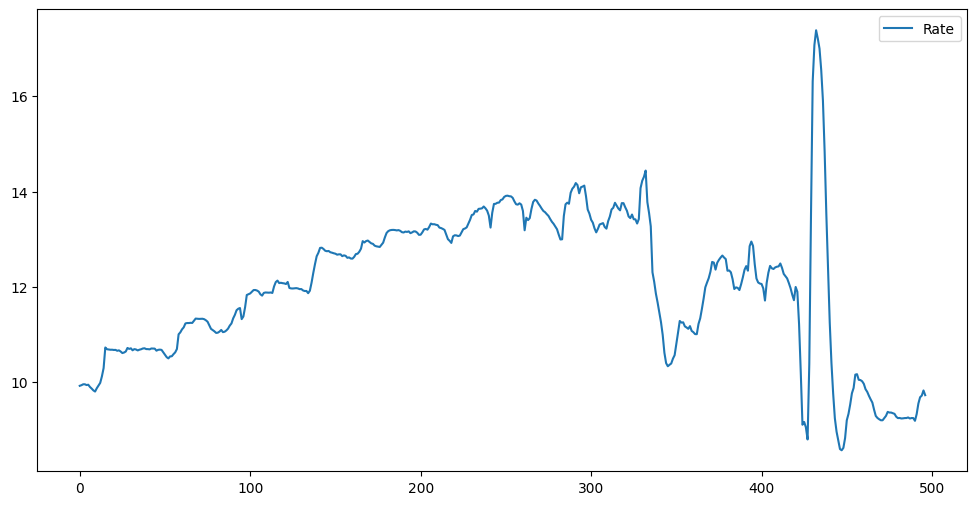

In [ ]:
#plot line graph
df.plot(figsize=(12,6))


Data Cleaning

In [ ]:
#we check for missing values
df.isnull().sum()

,0
Date,0
Rate,0


array([[<Axes: title={'center': 'Rate'}>]], dtype=object)

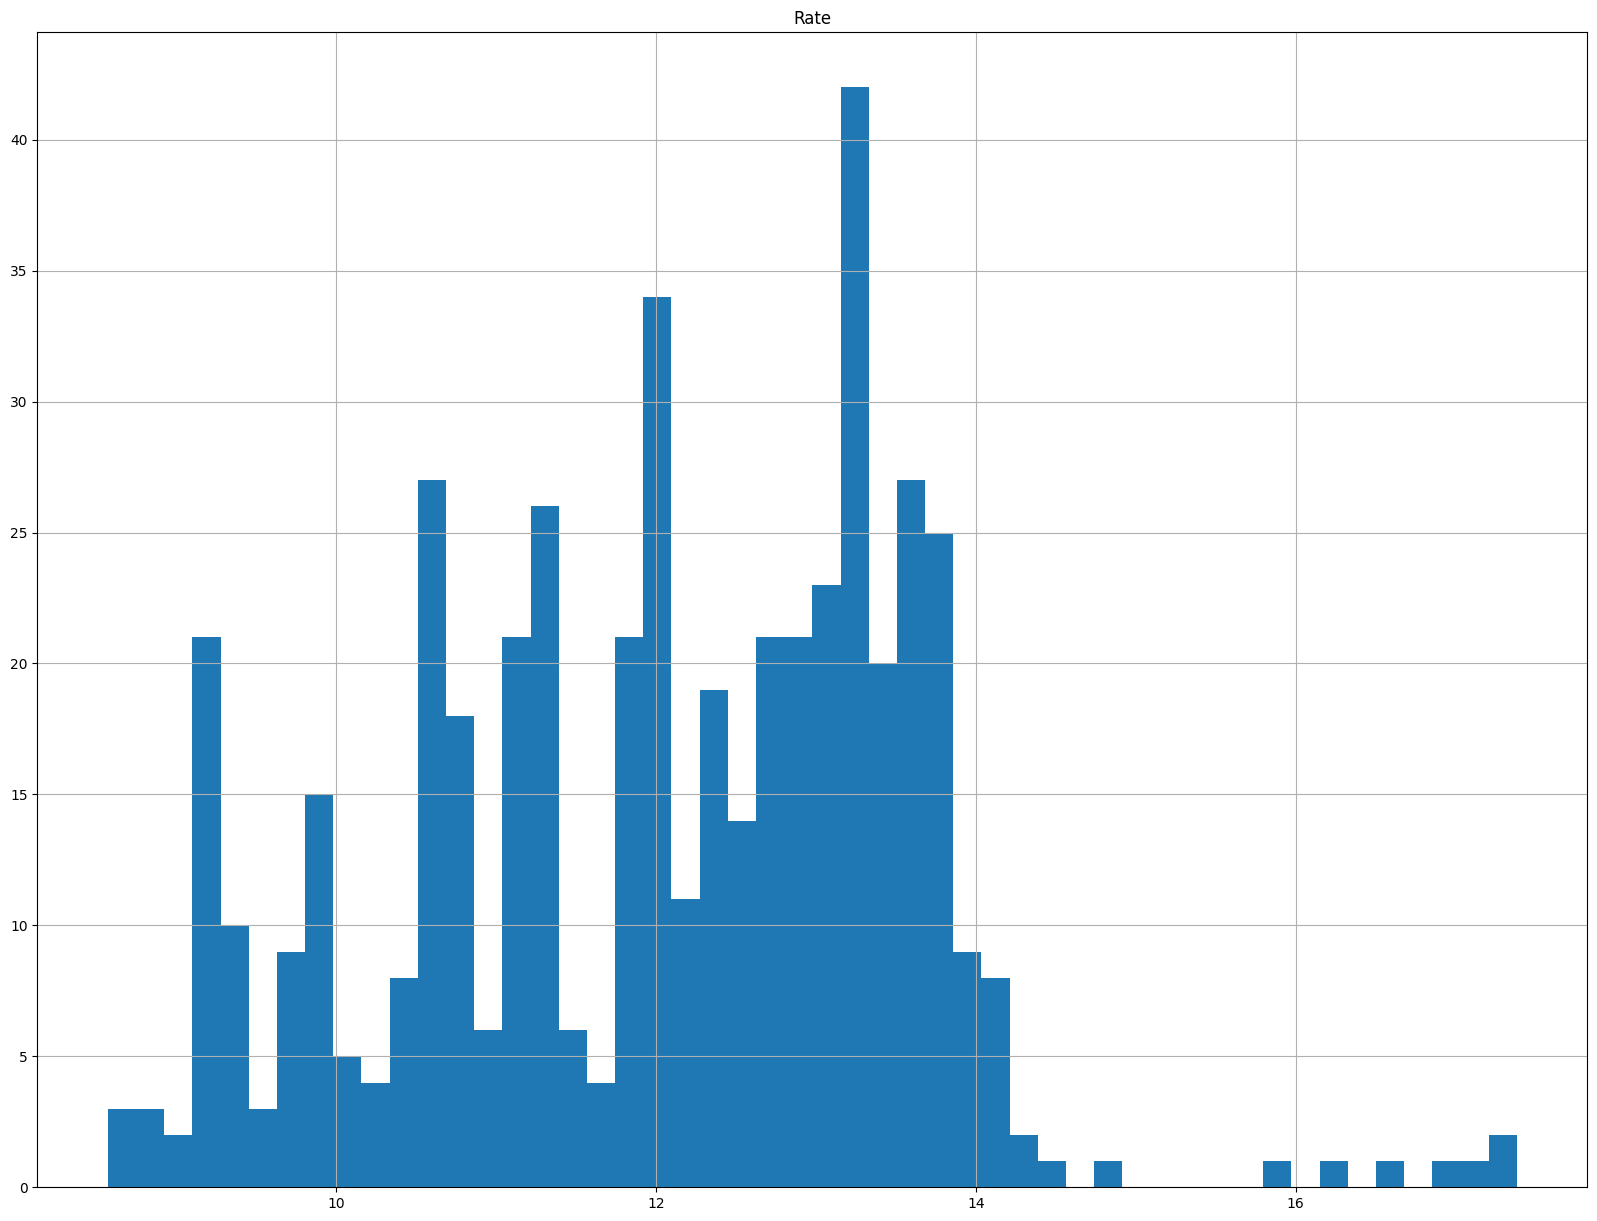

In [ ]:
# we wont check for duplicates because daily interbank rates are close to each other
#plot a histogram
df.hist(bins=50, figsize=(20,15))



In [ ]:
#drop the first column
data = df.drop(df.columns[0], axis=1)
data.head()

,Rate
0,9.9247
1,9.9373
2,9.9563
3,9.9566
4,9.9402


In [ ]:
data.shape

(497, 1)

In [ ]:
#pre process the time series for LSTM
#fit an LSTM model
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_data.shape


(497, 1)

In [ ]:
#create time series sequence
time_step = 20
#X, y = create_sequences(scaled_data, time_step)
X = []
y = []
for i in range(len(scaled_data)-time_step):
    X.append(scaled_data[i:i+time_step])
    y.append(scaled_data[i+time_step])

#reshaping for LSTM
X = np.array(X)
y = np.array(y)
#
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [ ]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape
X_test.shape

(96, 20, 1)

In [ ]:

#Build LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Build LSTM model
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Regularization to prevent overfitting
model.add(LSTM(20, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
#Define output layer of LSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
#model.fit(X_train, y_train, epochs=200, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_stopping])
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}, Test Loss: {test_loss}')

Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0012 - val_loss: 0.0130
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 8.6673e-04 - val_loss: 0.0131
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - val_loss: 0.0129
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.0464e-04 - val_loss: 0.0126
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.1649e-04 - val_loss: 0.0123
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.6506e-04 - val_loss: 0.0125
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.2272e-04 - val_loss: 0.0121
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0127
Epoch 9/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.3271e-04 - val_loss: 0.0116
Epoch 10/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.5355e-04 - val_loss: 0.0114
Epoch 11/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0011 - val_loss: 0.0113
Epoch 12/200
39/39 ━━━━━

In [ ]:
#reshape output
predict=model.predict(X_test)

#scale back prdiction
predict = scaler.inverse_transform(predict)
#

print("y_test:", y_test.shape, "y_pred:", predict.shape)
#make prediction with model
#print prediction next 10 values
print(predict[:10])
print(predict)




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
y_test: (96, 1) y_pred: (96, 1)
[[12.027886]
 [12.002124]
 [11.794047]
 [11.945535]
 [12.259483]
 [12.496356]
 [12.491885]
 [12.403112]
 [12.375012]
 [12.392793]]
[[12.027886 ]
 [12.002124 ]
 [11.794047 ]
 [11.945535 ]
 [12.259483 ]
 [12.496356 ]
 [12.491885 ]
 [12.403112 ]
 [12.375012 ]
 [12.392793 ]
 [12.413273 ]
 [12.462597 ]
 [12.413113 ]
 [12.278727 ]
 [12.186653 ]
 [12.14177  ]
 [12.077592 ]
 [11.980963 ]
 [11.850004 ]
 [11.723529 ]
 [11.887215 ]
 [11.954925 ]
 [11.482862 ]
 [10.532959 ]
 [ 9.398869 ]
 [ 8.834373 ]
 [ 8.71523  ]
 [ 8.70037  ]
 [ 9.613967 ]
 [12.538569 ]
 [16.231133 ]
 [17.177399 ]
 [16.622486 ]
 [16.217024 ]
 [16.214745 ]
 [15.941472 ]
 [15.287572 ]
 [14.236751 ]
 [12.983098 ]
 [11.90192  ]
 [10.909598 ]
 [10.115026 ]
 [ 9.533439 ]
 [ 9.10392  ]
 [ 8.846078 ]
 [ 8.72226  ]
 [ 8.643589 ]
 [ 8.62338  ]
 [ 8.669152 ]
 [ 8.819498 ]
 [ 9.120451 ]
 [ 9.389261 ]
 [ 9.596074 ]
 [ 9.781428 ]
 [ 9.906728 ]
 [10.082369 ]
 [10.173745 ]


In [ ]:
#check accuracy of model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt

# Calculate accuracy metrics
# make y have the same number of output as predict
y = y[:len(predict)]


rmse= sqrt(mean_squared_error(y_test, predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)

print(f'RMSE: {rmse}, MAE: {mae}, R2: {r2}')

RMSE: 10.61330974063891, MAE: 10.456292748081749, R2: -1852.4063395017508
